In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.family'] = 'Arial'
import glob

files = np.sort(glob.glob("RDP_results/*_hier_copynum.txt"));

In [4]:
soils = [];
ph = [];
for file in files:
    #load copynumber adjusted RDP output files
    df = pd.read_csv(file,sep="\t",error_bad_lines=False,skiprows=6,header=None)
    df.columns = ['Rank','Name','Abundance']

    total = df.iloc[0].Abundance

    #Remove rows with zero abundance
    df = df.iloc[np.where(df.Abundance > 0.0)[0]]

    #Compute relative abundances
    df['RelativeAbundance'] = df.Abundance/total

    unclassified_root = df.iloc[np.where(df.Name == 'unclassified_Root')[0]]
    unclassified_bacteria = df.iloc[np.where(df.Name == 'unclassified_Bacteria')[0]]
    unclassified_archaea = df.iloc[np.where(df.Name == 'unclassified_Archaea')[0]]
    unclassified_eukaryota = df.iloc[np.where(df.Name == 'unclassified_Eukaryota')[0]]

    #Keep only abundances at the level of order
    df = df.iloc[np.where(df.Rank == 'order')[0]]
    
    #Keep only taxa with abundance greater than 1%. Merge the rest into "Other classified"
    T = 0.05
    other_classified_total = np.sum(df['RelativeAbundance'].iloc[np.where(df.RelativeAbundance < T)[0]].values)
    df = df.iloc[np.where(df.RelativeAbundance >= T)[0]]
    df = pd.concat([unclassified_bacteria,unclassified_archaea,unclassified_eukaryota,unclassified_root,pd.DataFrame(data = {'Name':'Other classified',"RelativeAbundance":[other_classified_total]}),df])

    if file == files[0]:
        ra = df['RelativeAbundance']
        ra.index = df['Name'].values
        ra.name = file[21:23]
    else:
        df_temp = df['RelativeAbundance']
        df_temp.index = df['Name'].values
        df_temp.name = file[21:23]
        ra=pd.concat([ra,df_temp],axis=1)
    soils.append(file[12:14])
    ph.append(float(file[18:20])/10)
        
ra = ra.fillna(0)
ph = np.array(ph)
soils = np.array(soils)
samp_ids = np.array(ra.columns)

ra = ra.drop(index=['unclassified_Bacteria','Other classified'])
ra = ra.reindex(['Rhizobiales','Rhodocyclales','Burkholderiales','Pseudomonadales','Enterobacterales','Xanthomonadales'])

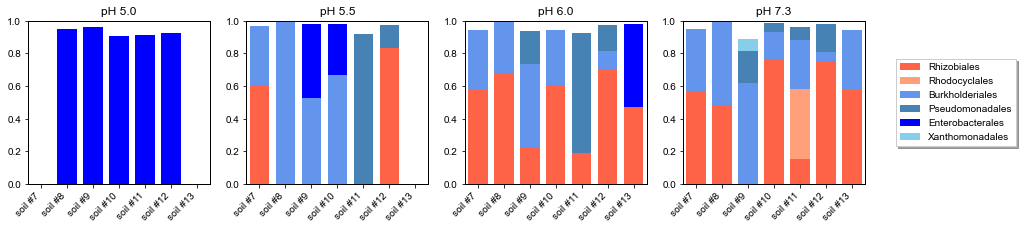

In [6]:
colors = ['tomato','lightsalmon','cornflowerblue','steelblue','blue','skyblue']
width=0.75
phs = np.unique(ph)
fig, axs = plt.subplots(1,4, figsize=(15, 3))

for j in range(0,len(phs)):
    ph_plot = phs[j]
    plot_idx = np.where(ph==ph_plot)[0]

    ra_sub = ra[samp_ids[plot_idx]]
    #Keep only taxa with nonzero abundance.
    T = 0.01
    # ra_sub = ra_sub[ra_sub > T].dropna(how='all').fillna(0)

    axs[j].bar(soils[plot_idx], ra_sub.iloc[0], width, label=ra_sub.iloc[0].name,color=colors[0])
    heights = ra_sub.iloc[0]
    for i in range(1,len(ra_sub)):
        if j == 0:
            axs[j].bar(x=range(1,6), height=ra_sub.iloc[i], width=width, label=ra_sub.iloc[i].name,bottom = heights,color=colors[i]) #kluge
        else:
            axs[j].bar(range(0,len(plot_idx)), ra_sub.iloc[i], width, label=ra_sub.iloc[i].name,bottom = heights,color=colors[i])
        heights = heights + ra_sub.iloc[i]
    axs[j].set_title('pH '+str(ph_plot));
    axs[j].set_ylim([0,1]);
    axs[j].set_xlim([-0.5,6.5]);
    #axs[j].set_xticks(ticks=range(0,7),labels=['soil #7','soil #8','soil #9', 'soil #10', 'soil #11', 'soil #12', 'soil #13'],ha='right',rotation=45)
    axs[j].set_xticks(ticks=range(0, 7))
    axs[j].set_xticklabels(['soil #7', 'soil #8', 'soil #9', 'soil #10', 'soil #11', 'soil #12', 'soil #13'], ha='right', rotation=45)

axs[-1].legend(loc='center', bbox_to_anchor=(1.5, 0.5), fancybox=False, shadow=True);
# plt.savefig('Enrichment2_mitags.svg')